# III. Mapmaking with CartoPy

## Table of Contents
1. Projections

In [1]:
import cartopy as cp
from cartopy.io.img_tiles import Stamen

## Map Projections

### Plate Carree

In [ ]:
tiler = Stamen('terrain-background')
mercator = tiler.crs

fig = plt.figure()
ax1 = fig.add_subplot(2,1, 1, projection=mercator)
ax1.set_extent([-180, 180, -90, 34], crs=cp.crs.PlateCarree())
ax1.add_image(tiler, 6)
ax1.coastlines('10m')

ax2 = fig.add_subplot(2,1,2, projection=None)
ax2.set_extent([-180, 180, -90, 34], crs=cp.crs.PlateCarree())
ax2.add_image(tiler, 6)
ax2.coastlines('10m')
plt.show()

### Mollweide

In [35]:
cp.crs.Mollweide()

### Orthographic

In [36]:
cp.crs.Orthographic()

#### Plotting the Aurora Forecast from NOAA on Orthographic Polar Projection

The National Oceanic and Atmospheric Administration (NOAA) monitors the
solar wind conditions using the ACE spacecraft orbiting close to the L1
Lagrangian point of the Sun-Earth system. This data is fed into the
OVATION-Prime model to forecast the probability of visible aurora at
various locations on Earth. Every five minutes a new forecast is
published for the coming 30 minutes. The data is provided as a
1024 by 512 grid of probabilities in percent of visible aurora. The
data spaced equally in degrees from -180 to 180 and -90 to 90.

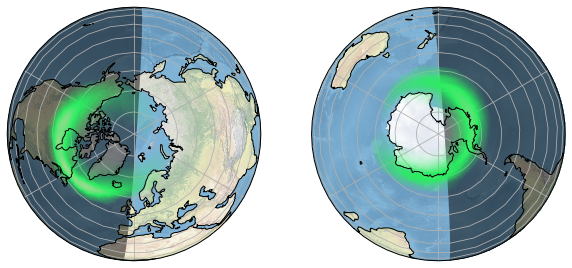

In [3]:
__tags__ = ["Scalar data"]
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen

from io import StringIO

import numpy as np
from datetime import datetime
import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


def aurora_forecast():
    """
    Get the latest Aurora Forecast from https://www.swpc.noaa.gov.
    Returns
    -------
    img : numpy array
        The pixels of the image in a numpy array.
    img_proj : cartopy CRS
        The rectangular coordinate system of the image.
    img_extent : tuple of floats
        The extent of the image ``(x0, y0, x1, y1)`` referenced in
        the ``img_proj`` coordinate system.
    origin : str
        The origin of the image to be passed through to matplotlib's imshow.
    dt : datetime
        Time of forecast validity.
    """

    # GitHub gist to download the example data from
    url = ('https://gist.githubusercontent.com/belteshassar/'
           'c7ea9e02a3e3934a9ddc/raw/aurora-nowcast-map.txt')
    # To plot the current forecast instead, uncomment the following line
    # url = 'https://services.swpc.noaa.gov/text/aurora-nowcast-map.txt'

    response_text = StringIO(urlopen(url).read().decode('utf-8'))
    img = np.loadtxt(response_text)
    # Read forecast date and time
    response_text.seek(0)
    for line in response_text:
        if line.startswith('Product Valid At:', 2):
            dt = datetime.strptime(line[-17:-1], '%Y-%m-%d %H:%M')

    img_proj = ccrs.PlateCarree()
    img_extent = (-180, 180, -90, 90)
    return img, img_proj, img_extent, 'lower', dt


def aurora_cmap():
    """Return a colormap with aurora like colors"""
    stops = {'red': [(0.00, 0.1725, 0.1725),
                     (0.50, 0.1725, 0.1725),
                     (1.00, 0.8353, 0.8353)],

             'green': [(0.00, 0.9294, 0.9294),
                       (0.50, 0.9294, 0.9294),
                       (1.00, 0.8235, 0.8235)],

             'blue': [(0.00, 0.3843, 0.3843),
                      (0.50, 0.3843, 0.3843),
                      (1.00, 0.6549, 0.6549)],

             'alpha': [(0.00, 0.0, 0.0),
                       (0.50, 1.0, 1.0),
                       (1.00, 1.0, 1.0)]}

    return LinearSegmentedColormap('aurora', stops)


def main():
    fig = plt.figure(figsize=[10, 5])

    # We choose to plot in an Orthographic projection as it looks natural
    # and the distortion is relatively small around the poles where
    # the aurora is most likely.

    # ax1 for Northern Hemisphere
    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.Orthographic(0, 90))

    # ax2 for Southern Hemisphere
    ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.Orthographic(180, -90))

    img, crs, extent, origin, dt = aurora_forecast()

    for ax in [ax1, ax2]:
        ax.coastlines(zorder=3)
        ax.stock_img()
        ax.gridlines()
        ax.add_feature(Nightshade(dt))
        ax.imshow(img, vmin=0, vmax=100, transform=crs,
                  extent=extent, origin=origin, zorder=2,
                  cmap=aurora_cmap())

    plt.show()


if __name__ == '__main__':
    main()